# Convolutional Neural Networks

## A theoretical overview
Convolutional neural networks are specifically designed to analyze images with layers developed to emulate the functioning of the visual cortex in biological organisms. They analyze separately different regions of the image in order to recognize patterns indipendently from their position and reduce the overall complexity of the model to avoid overfitting.

The architecture of the models used in this notebook are essentially analogous to a feedforward neural network with the addition of two new types of layer: convolutional layers and pooling layers. These layers are usually used in blocks of some convolutional layers followed by a pooling one, gradually reducing the dimensions of the features' maps and incrementing the number of filters (see some examples of established architectures in Géron, 2019). Finally all the maps are flattened and connected to dense layers which reach the output layer of the necessary size.

### Convolutional layer
In a 2D convolutional layer the parameters are organized in a set of filters, which are matrices of smaller dimensions than the input matrix. The weights contained in these matrices get updated during the training process. The layer works as follows: each filter passes along the input matrix generating a feature map in which each pixel's value is obtained from the convolution of the filter with the region of the input matrix considered at the respective step. The convolution of the two matrix, of the same dimensions, consists in an element-wise multiplication followed by the summation of all the obtained values.
This process is shown in the following image (from _Machine learning glossary_, n.d.).

<center>
    <br/>
    <img src="./images/AnimatedConvolution.gif" width="30%">
</center>

After the convolution an activation function could also be applied.

### Pooling layers 
Pooling layers behave in the same way of convolutional layers, i.e. considering step by step a different slice of the input matrix, but do not have any trainable parameter.
Instead, the feature map is generated taking the maximum pixel's value in the region considered (max pooling layers) or averaging those values (average pooling layers).
The aim of these layers is usually that of reducing the size of the feature maps trying to condensate the information stored in the image. For example, neighboring pixels are often highly correlated assuming very similar values, a pooling layers helps removing the redondant data.


## Hyperparameters

Most hyperparameters of convolutional neural networks are analogous to the ones of feed forward networks. They include the activation functions, the optimizer with its hyperparameters and the choice of the overall architecture requiring to choose the number of layers, their dimensions and the order in which they appear.

As in the previous notebook, for feedforward neural networks, I have used the Adam optimizer, with the default values of its hyperparameters, which seemed to work well. Some tests made with different optimizers have not shown better performances. I also early stopped the training, monitoring the validation loss and interrupting the process if it does not improve for 7 epochs.

The new hyperparameters regards convolutional layers. In addition to the filters' size and the number of feature's map it is necessary to define strides and padding. The former defines the number of pixels the filter is moved vertically and horizontally during its application to the input. The latter defines the number of padding pixels to add to the input matrix which can be required to make sure that the filter does not fall out of the input image.
In the models trained in this notebook I have used the `padding=same` parameter which automatically sets the padding to produce feature maps of the same dimensions of the input (see _Conv2D layer_, n.d.).

## Trained and tested models

After some tests aimed at exploring how different choices lead to different performances, I have decided to present and compare in this notebook the following three different models.

### LeNet5
LeNet5 is one of the earliest convolutional neural networks published, firstly applied to handwritten zipe code recognition (LeCun, 1989). I have kept the same structure of the original model keeping the same filter's size. However,since the input images have different dimensions, the features maps result in different sizes too.
Like the original paper I have used the `tanh()` activation functions in the convolutional layers, and average pooling layers instead of today's more common max pooling layers.
I have however modified the activation function of the output layer using `softmax` like in all the other models.

The model is summarized in this image
<center>
    <br/>
    <img src="./images/leNet.png" width="70%">
</center>

### singleConvCNN
This neural network it is not instead an established model. However in its design I took inspiration from the general features shared by most of the well known architectures (Géron, 2019).
It is composed of three blocks of a convolutional layer followed by a max pooling layer. Each max pooling layer reduces by half both the dimensions of the input image while the convolutional layer of the following block doubles the depth, i.e. the number of features maps. 
After three of these blocks the data tensor is flattened and connected to two dense layers gradually reducing their dimensions up to that of the output layer which is always a 22 neurons, softmax, dense layer.

The network, summarized above, is shown in this image
<center>
    <br/>
    <img src="./images/singleCNN.png" width="70%">
</center>

### doubleConvCNN 
This last model is very similar to the precedent with a simple modification that increments its complexity:
each block contains two identical convolution layers before of the respective max pooling layer.

A summary of this network is shown in this image:
<center>
    <br/>
    <img src="./images/doubleCNN.png" width="100%">
</center>


I have also tried to train the same models with the addition of a dropout (with rate=0.5) layer after the flattening of the data and before the part of the network with dense layers. 
The dropout layer randomly drops, during the training process, a fraction (rate) of the connections between the two layers where is placed. The connections to drop are randomly selected at each step of the training process. When the neural network is trained it gets deployed with all the connections restored.
This should force the neural network to not rely too much on single connections and help thus producing more robust models resulting in lower generalization errors.

All these models are defined in `models.py`. In the following cell they are loaded and their summary generated by tensorflow is printed showing also the number of trainable parameters of each of them.
Compared to all the feed forward models used in this project, these convolutional networks are more complex with a larger number of trainable parameters. However, in this case all the 71x60x3 image is provided in input to the network without further reduction.

In [2]:
# imports
import my_utils as u
import numpy as np
import tensorflow as tf

In [3]:
import models

models_totry = [models.singleConvCNN(), models.doubleConvCNN(), models.LeNet5(), models.singleConvCNN(dropout=True), models.doubleConvCNN(dropout=True), models.LeNet5(dropout=True)]
for model in models_totry:
    model.summary()

Model: "singleConvCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 60, 71, 3)]       0         
_________________________________________________________________
b1_c1 (Conv2D)               (None, 60, 71, 8)         224       
_________________________________________________________________
b1_p (MaxPooling2D)          (None, 30, 36, 8)         0         
_________________________________________________________________
b2_c1 (Conv2D)               (None, 30, 36, 16)        1168      
_________________________________________________________________
b2_p (MaxPooling2D)          (None, 15, 18, 16)        0         
_________________________________________________________________
b3_c1 (Conv2D)               (None, 15, 18, 32)        4640      
_________________________________________________________________
b3_p (MaxPooling2D)          (None, 8, 9, 32)        

## Training

In [12]:
#loading training data
x_train, y_train, df_data = u.get_images(u.train_files)
#rescaling pixel values in the [0;1] range
x_train = x_train/256

100%|██████████████████████████████████████| 22348/22348 [00:23<00:00, 950.14it/s]


In [13]:
#loading test data
x_test, y_test, df_data = u.get_images(u.test_files)
#rescaling pixel values in the [0;1] range
x_test = x_test/256

100%|████████████████████████████████████████| 4720/4720 [00:04<00:00, 992.67it/s]


In [14]:
x_train.shape

(22348, 60, 71, 3)

In [15]:
#changing format of labels
y_train_mrx = np.array([[int(i==y) for i in range(0,22)] for y in y_train])
y_test_mrx = np.array([[int(i==y) for i in range(0,22)] for y in y_test])

In [7]:
#training
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer
import os
import pickle

for model in models_totry:

        #compiling model with Adam optimizer
        model.compile(keras.optimizers.Adam(), loss='categorical_crossentropy')

        print(f"Model {model.name} prepared. Architecture:")
        model.summary()

        #preparing callback for early stopping
        es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)

        #start training
        print("Starting to fit model")
        history = model.fit(x=x_train, y=y_train_mrx, epochs=20, verbose=True, shuffle=True, validation_data=(x_test, y_test_mrx), callbacks=[es])
    
        #saving trained model
        print("fit completed, saving model")

        #preparaing saving dir
        saving_dir = f"{model.name}.CNN"
        os.mkdir(saving_dir)
        
        #saving history
        with open(f"{saving_dir}/history.hist", 'wb') as file_h:
            pickle.dump(history.history, file_h)
            
        #saving model
        model.save(saving_dir)

 0.2825 - val_loss: 0.3002
Epoch 3/20
699/699 [==============================] - 68s 97ms/step - loss: 0.2084 - val_loss: 0.2370
Epoch 4/20
699/699 [==============================] - 68s 97ms/step - loss: 0.1622 - val_loss: 0.2570
Epoch 5/20
699/699 [==============================] - 68s 97ms/step - loss: 0.1474 - val_loss: 0.2467
Epoch 6/20
699/699 [==============================] - 69s 98ms/step - loss: 0.1187 - val_loss: 0.2248
Epoch 7/20
699/699 [==============================] - 71s 101ms/step - loss: 0.1062 - val_loss: 0.2492
Epoch 8/20
699/699 [==============================] - 71s 101ms/step - loss: 0.0925 - val_loss: 0.2693
Epoch 9/20
699/699 [==============================] - 71s 102ms/step - loss: 0.0857 - val_loss: 0.3185
Epoch 10/20
699/699 [==============================] - 74s 106ms/step - loss: 0.0713 - val_loss: 0.3286
Epoch 11/20
699/699 [==============================] - 72s 103ms/step - loss: 0.0741 - val_loss: 0.3413
Epoch 12/20
699/699 [===========================

## Results

In this section I will compare the trained models.

First of all I will show how the loss function computed on the training and on the test set changed during the training process. This images will provide a first impression of the models' performances and are useful to qualitatively asses if the networks were trained correctly.

I will then compute and show the normalized confusion matrices of all the trained models.

Then I will compute the 4 metrics computed also for all the other methods: Accuracy, Balanced accuracy, F1-score and MCC.

Finally, based on this information I will select the better model.

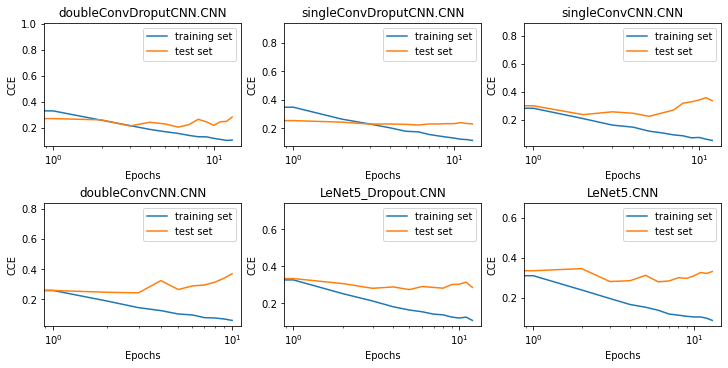

In [11]:
#plot cross entropy minimization during training
import pickle
import matplotlib.pyplot as plt
import re
import os

mod_name_re = re.compile(".*\.CNN$")
models = [s for s in os.listdir('./') if mod_name_re.match(s)]
fig, axs = plt.subplots(2,int(len(models)/2), figsize=(10, 5), constrained_layout=True)

axs = axs.flatten()

for j, model in enumerate(models):
    with open(f"./{model}/history.hist", 'rb') as hist:
        history = pickle.load(hist)
    axs[j].plot(history['loss'], label='training set')
    axs[j].plot(history['val_loss'], label='test set')
    axs[j].set_xscale('log')
    axs[j].set_xlabel('Epochs')
    axs[j].set_ylabel('CCE')
    axs[j].set_title(f"{model}")
    axs[j].legend()

The trainings of all of the models were early stopped after about 10 epochs. From the loss history it is possible to observe that, while its value computed on the training set gets gradually lower, the value computed on the test set witness little or no reduction with respect to the value reached after the first epoch. 
These models easily overfit the data.

In [16]:
#loading all the models in a dataframe
import pandas as pd
import tensorflow.keras as keras
results_df = pd.DataFrame()

for i, model in enumerate(models):
        print(f'opening model {model}')
        kmod = keras.models.load_model(f'./{model}')
        new_entry = {'model_name': model, 'model': kmod}
        results_df = results_df.append(new_entry, ignore_index=True)

#importing tqdm for progress bar
from tqdm import tqdm
tqdm.pandas()

#computing the predictions of each model on the test set
results_df['predicted_y_p'] = results_df['model'].progress_apply(lambda classif: classif.predict(x_test))
results_df['predicted_y'] = results_df['predicted_y_p'].progress_apply(lambda p: p.argmax(axis=1))

opening model doubleConvDroputCNN.CNN
opening model singleConvDroputCNN.CNN
opening model singleConvCNN.CNN
opening model doubleConvCNN.CNN
opening model LeNet5_Dropout.CNN
opening model LeNet5.CNN


  0%|                                                       | 0/6 [00:00<?, ?it/s]2022-02-03 15:51:14.572403: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 241286400 exceeds 10% of free system memory.
2022-02-03 15:51:15.750803: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-03 15:51:15.800155: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2594540000 Hz
100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 1724.75it/s]


In [17]:
from sklearn.metrics import confusion_matrix

#computing confusion matrix for each model
results_df['cmatrix'] = results_df['predicted_y'].progress_apply(lambda y_pred: confusion_matrix(y_test, y_pred))

#computing, for each model, the confusion matrix 
#with each element normalized with the number of elements 
#belonging to the same true class
results_df['cmatrix_truen'] = results_df['predicted_y'].progress_apply(lambda y_pred: confusion_matrix(y_test, y_pred, normalize='true'))

100%|██████████████████████████████████████████████| 6/6 [00:00<00:00, 178.81it/s]


In [18]:
models

['doubleConvDroputCNN.CNN',
 'singleConvDroputCNN.CNN',
 'singleConvCNN.CNN',
 'doubleConvCNN.CNN',
 'LeNet5_Dropout.CNN',
 'LeNet5.CNN']

/tmp/ipykernel_455950/4240995028.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


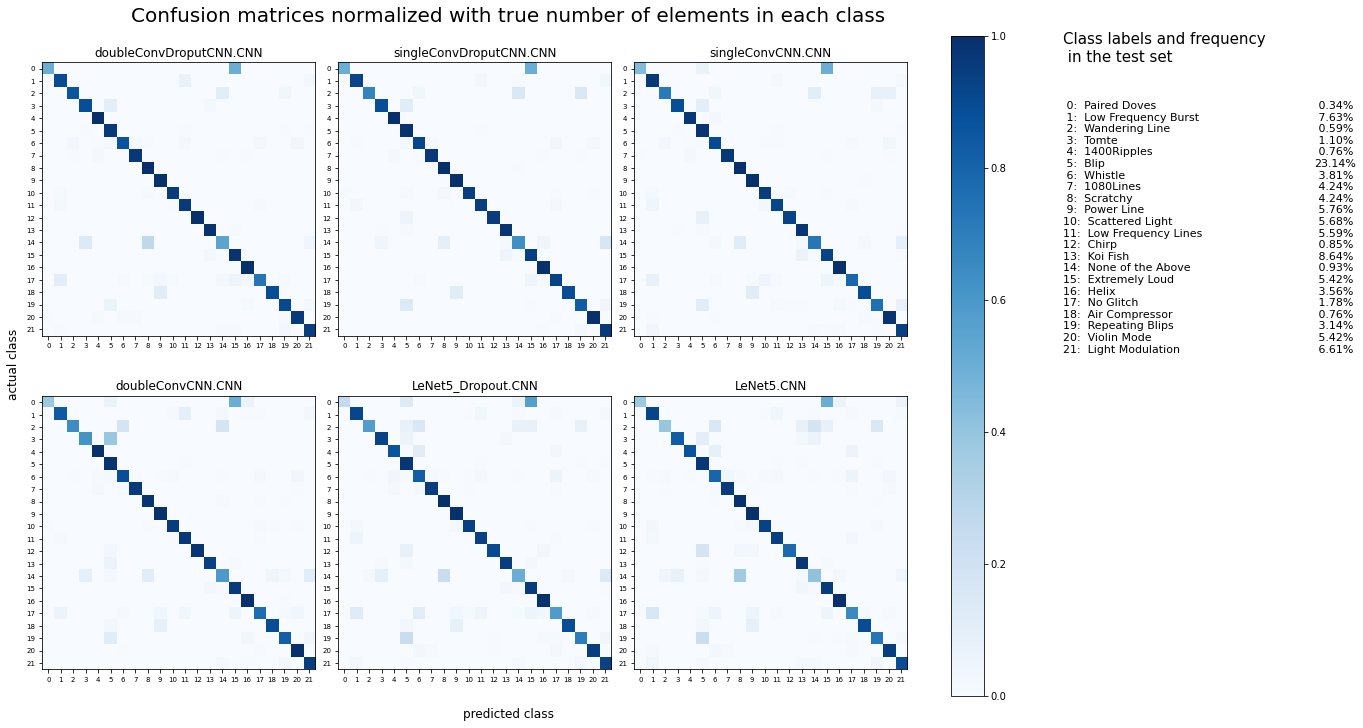

In [19]:
#plotting confusion matrices
fig, axs = plt.subplots(2, int(len(models)/2), figsize=(14, 10), constrained_layout=True)

for i, ax in enumerate(axs.flatten()):
        cmat = results_df['cmatrix_truen'].iloc[i]
        im = ax.imshow(cmat, cmap='Blues')
        ax.set_title(f"{results_df.iloc[i]['model_name']}")
        ax.set_xticks(range(0,22))
        ax.set_yticks(range(0,22))
        ax.tick_params(axis='both', which='major', labelsize=7)

fig.suptitle('Confusion matrices normalized with true number of elements in each class', fontsize=20)
fig.supxlabel('predicted class')
fig.supylabel('actual class')

fig.colorbar(im,  ax=axs.ravel().tolist())

#generate class legend
fig.text(1.05, 0.92, "Class labels and frequency\n in the test set", fontsize=15)
class_labels = u.get_class_labels()
class_labels['test_perc'] = class_labels['n_test']*100/class_labels['n_test'].sum()
classes=""
perc=""
for i, row in class_labels.iterrows():
    classes = classes + f"{row['class_id']:>2}:  {row['class'].replace('_', ' '):<25}\n"
    perc = perc + f"{row['test_perc']:>5.2f}%\n"

fig.text(1.05, 0.50, classes, fontsize=11)
fig.text(1.3, 0.50, perc, fontsize=11) 
fig.show()

The confusion matrices in the figure above give a first impression of the models' performances. 
They seem similar to the ones computed for the previously used methods. The misclassifcation problem of 'Paired Doves' elements remains.
Furthermore, the LeNet5 architecture seems to provide worse results than the other models even with the addition of the dropout layer. This might be due to the use of the saturating `tanh` activation function.

In [20]:
#computing metrics

#Accuracy and  balanced accuracy
def compute_balacc(cmat):
    bacc = 0
    for i, row in enumerate(cmat):
        bacc += row[i]/row.sum()
    return bacc/len(cmat)
results_df['accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: cmat.trace()/cmat.sum())
results_df['balanced_accuracy'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_balacc(cmat))

#F1-score and MCC
#F1 score
def compute_macroF1(cmat):
    mprec = 0
    mrec = 0
    #compute macro precision and macro recall
    for i in range(0, len(cmat)):
        mprec += (cmat[i][i]/(cmat[:,i].sum()+1e-20))
        mrec  += (cmat[i][i]/(cmat[i].sum()+1e-20))
   
    mprec /= len(cmat)
    mrec  /= len(cmat)

    return 2*(mprec*mrec)/(mprec+mrec)

def compute_MCC(cmat):
    c = cmat.trace()
    s = cmat.sum()
    p = [cmat[:,k].sum()+1e-20 for k in range(0, len(cmat))]
    t = [cmat[k].sum() for k in range(0, len(cmat))]

    mcc = (c*s - np.dot(p,t))/np.sqrt((s**2-np.dot(p,p))*(s**2-np.dot(t,t)))
    return mcc

results_df['macroF1'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_macroF1(cmat))
results_df['MCC'] = results_df['cmatrix'].progress_apply(lambda cmat: compute_MCC(cmat))

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 3313.04it/s]


In [22]:
results_df[['model_name', 'accuracy', 'balanced_accuracy', 'macroF1', 'MCC']].round(4)

,model_name,accuracy,balanced_accuracy,macroF1,MCC
0,doubleConvDroputCNN.CNN,0.9468,0.8992,0.9026,0.9414
1,singleConvDroputCNN.CNN,0.9564,0.9021,0.9174,0.9518
2,singleConvCNN.CNN,0.9462,0.8892,0.8991,0.9405
3,doubleConvCNN.CNN,0.9377,0.8664,0.8817,0.9312
4,LeNet5_Dropout.CNN,0.9271,0.8406,0.8666,0.9194
5,LeNet5.CNN,0.9227,0.8258,0.8545,0.9145


This table presents the metrics of each model. 

All the architectures are observed to benefit from the introduction of the dropout layer with an increment of 1 to 2 percentage points for all of the computed metrics.

As already mentioned the LeNet5 architecture provided the worse results. The singleConv model, with less trainable parameters of all the others, has the greatest scores.

## Conclusion

The convolutional neural network that provided the best results was the `singleConvDropoutCNN`.

From its application to the test set it obtained the following scores.

    Accuracy: 95.64%
    Balanced Accuracy: 90.21%
    F1-score: 91.74%
    MCC: 95.18%

## References

_Conv2D layer - keras documentation_, Available at
https://keras.io/api/layers/convolution_layers/convolution2d/

Géron, Aurélien. _Hands-on machine learning with Scikit-Learn, Keras, and TensorFlow: Concepts, tools, and techniques to build intelligent systems._ O'Reilly Media, 2019.

Google developers. _Machine learning glossary_, Available at: https://developers.google.com/machine-learning/glossary/#convolutional_neural_network

LeCun, Yann, et al. _Backpropagation applied to handwritten zip code recognition._ Neural computation 1.4 (1989): 541-551.